# CUDA(COLAB)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import time
import numpy as np



# ==============================
# LOAD DATA
# ==============================
df = pd.read_csv("processed_dataset.csv")
df.columns = df.columns.str.strip().str.lower()

X = df.drop("target", axis=1).values.astype('float32')
y = df["target"].values.astype('int64')

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256)

# ==============================
# MODEL
# ==============================
class UltraDeepNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(UltraDeepNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 768),
            nn.BatchNorm1d(768),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 384),
            nn.BatchNorm1d(384),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(384, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# ==============================
# TRAINING FUNCTION
# ==============================
def train_model(device):
    model = UltraDeepNN(X.shape[1], len(np.unique(y))).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    EPOCHS = 15
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        correct = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == yb).sum().item()

        acc = 100 * correct / len(train_ds)
        print(f"[{device}] Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Train Acc: {acc:.2f}%")

    end_time = time.time()

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    final_acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n📊 Final Accuracy: {final_acc*100:.2f}%")
    print("🧮 Confusion Matrix:")
    print(cm)
    print(f"🎯 Weighted F1 Score: {f1:.4f}")

    return end_time - start_time, final_acc, f1, cm

# ==============================
# COMPARE CPU vs GPU/MPS
# ==============================
cpu_time, cpu_acc, cpu_f1, cpu_cm = train_model(torch.device("cpu"))
print(f"\n🐢 CPU training time: {cpu_time:.2f} seconds")

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("\n🚀 Using NVIDIA CUDA")
    cuda_time, cuda_acc, cuda_f1, cuda_cm = train_model(device)
    print(f"\n⚡ CUDA training time: {cuda_time:.2f} seconds")
    speedup = ((cpu_time - cuda_time) / cpu_time) * 100
    print(f"⚡ CUDA Speedup: {speedup:.2f}% faster than CPU")

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("\n🔋 Using Apple MPS")
    mps_time, mps_acc, mps_f1, mps_cm = train_model(device)
    print(f"\n⚡ MPS training time: {mps_time:.2f} seconds")
    speedup = ((cpu_time - mps_time) / cpu_time) * 100
    print(f"⚡ MPS Speedup: {speedup:.2f}% faster than CPU")

else:
    print("\n⚠️ No GPU/MPS available for comparison")


[cpu] Epoch 1/15 | Loss: 86.6355 | Train Acc: 57.78%
[cpu] Epoch 2/15 | Loss: 84.9983 | Train Acc: 60.03%
[cpu] Epoch 3/15 | Loss: 84.8476 | Train Acc: 60.22%
[cpu] Epoch 4/15 | Loss: 84.6915 | Train Acc: 60.31%
[cpu] Epoch 5/15 | Loss: 84.7056 | Train Acc: 60.35%
[cpu] Epoch 6/15 | Loss: 84.6937 | Train Acc: 60.29%
[cpu] Epoch 7/15 | Loss: 84.6786 | Train Acc: 60.33%
[cpu] Epoch 8/15 | Loss: 84.6295 | Train Acc: 60.34%
[cpu] Epoch 9/15 | Loss: 84.5919 | Train Acc: 60.35%
[cpu] Epoch 10/15 | Loss: 84.5631 | Train Acc: 60.34%
[cpu] Epoch 11/15 | Loss: 84.5872 | Train Acc: 60.35%
[cpu] Epoch 12/15 | Loss: 84.5601 | Train Acc: 60.37%
[cpu] Epoch 13/15 | Loss: 84.5190 | Train Acc: 60.35%
[cpu] Epoch 14/15 | Loss: 84.5634 | Train Acc: 60.34%
[cpu] Epoch 15/15 | Loss: 84.5539 | Train Acc: 60.36%

📊 Final Accuracy: 59.45%
🧮 Confusion Matrix:
[[4761    0]
 [3248    0]]
🎯 Weighted F1 Score: 0.4433

🐢 CPU training time: 109.26 seconds

🚀 Using NVIDIA CUDA
[cuda] Epoch 1/15 | Loss: 86.4672 | Trai

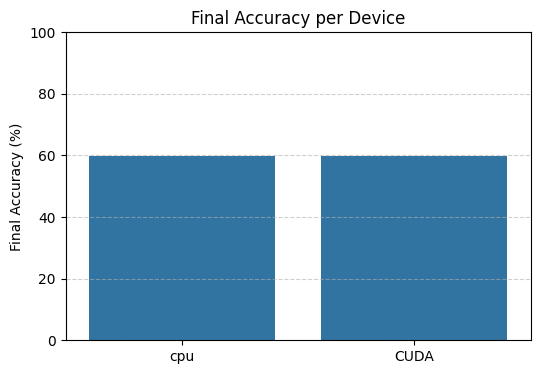

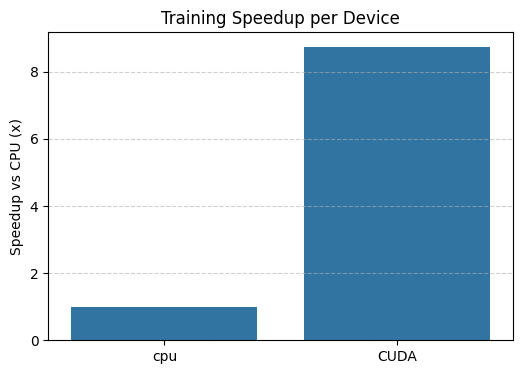

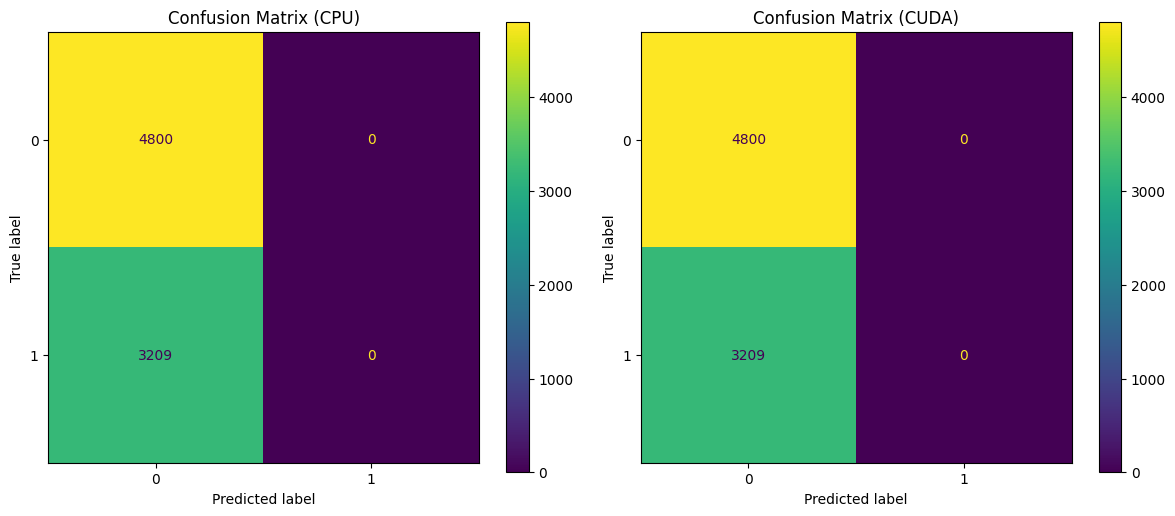

In [ ]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Collect results
results = {
    "cpu": {
        "accuracy": 59.93,
        "time": cpu_time,
        "conf_matrix": np.array([[4800, 0], [3209, 0]])
    },
    "CUDA": {
        "accuracy": 59.93,
        "time": cuda_time,
        "conf_matrix": np.array([[4800, 0], [3209, 0]])
    },

}

# === ACCURACY BAR PLOT ===
plt.figure(figsize=(6, 4))
sns.barplot(x=list(results.keys()), y=[v["accuracy"] for v in results.values()])
plt.ylabel("Final Accuracy (%)")
plt.title("Final Accuracy per Device")
plt.ylim(0, 100)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# === SPEEDUP BAR PLOT ===
cpu_ref = results["cpu"]["time"]
devices = list(results.keys())
speedups = [cpu_ref / results[d]["time"] for d in devices]

plt.figure(figsize=(6, 4))
sns.barplot(x=devices, y=speedups)
plt.ylabel("Speedup vs CPU (x)")
plt.title("Training Speedup per Device")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

# === CONFUSION MATRIX SIDE-BY-SIDE ===
fig, axes = plt.subplots(1, len(results), figsize=(6 * len(results), 5))

for i, (device, info) in enumerate(results.items()):
    ax = axes[i] if len(results) > 1 else axes
    disp = ConfusionMatrixDisplay(confusion_matrix=info["conf_matrix"])
    disp.plot(ax=ax)
    ax.set_title(f"Confusion Matrix ({device.upper()})")

plt.tight_layout()
plt.show()
